In [2]:
#基本套件和模組
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif'] = ['DFKai-sb']
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [3]:
#採用Kaggle - Human Resources Analytics
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
#先檢查資料的個數和基本型態
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
#了解數據--sales
df['sales'].value_counts()
#代表部門分布

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [5]:
#了解數據--salary
df['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [6]:
#了解數據--Work_accident
df['Work_accident'].value_counts()
#0代表無受傷，1代表工傷

0    12830
1     2169
Name: Work_accident, dtype: int64

In [7]:
#了解目標變數--left
size=df['left'].value_counts()
pct =df['left'].value_counts(normalize=True).round(2)
pd.DataFrame(zip(size,pct),columns=['次數','百分比'])
#0代表留職，1代表離開

,次數,百分比
0,11428,0.76
1,3571,0.24


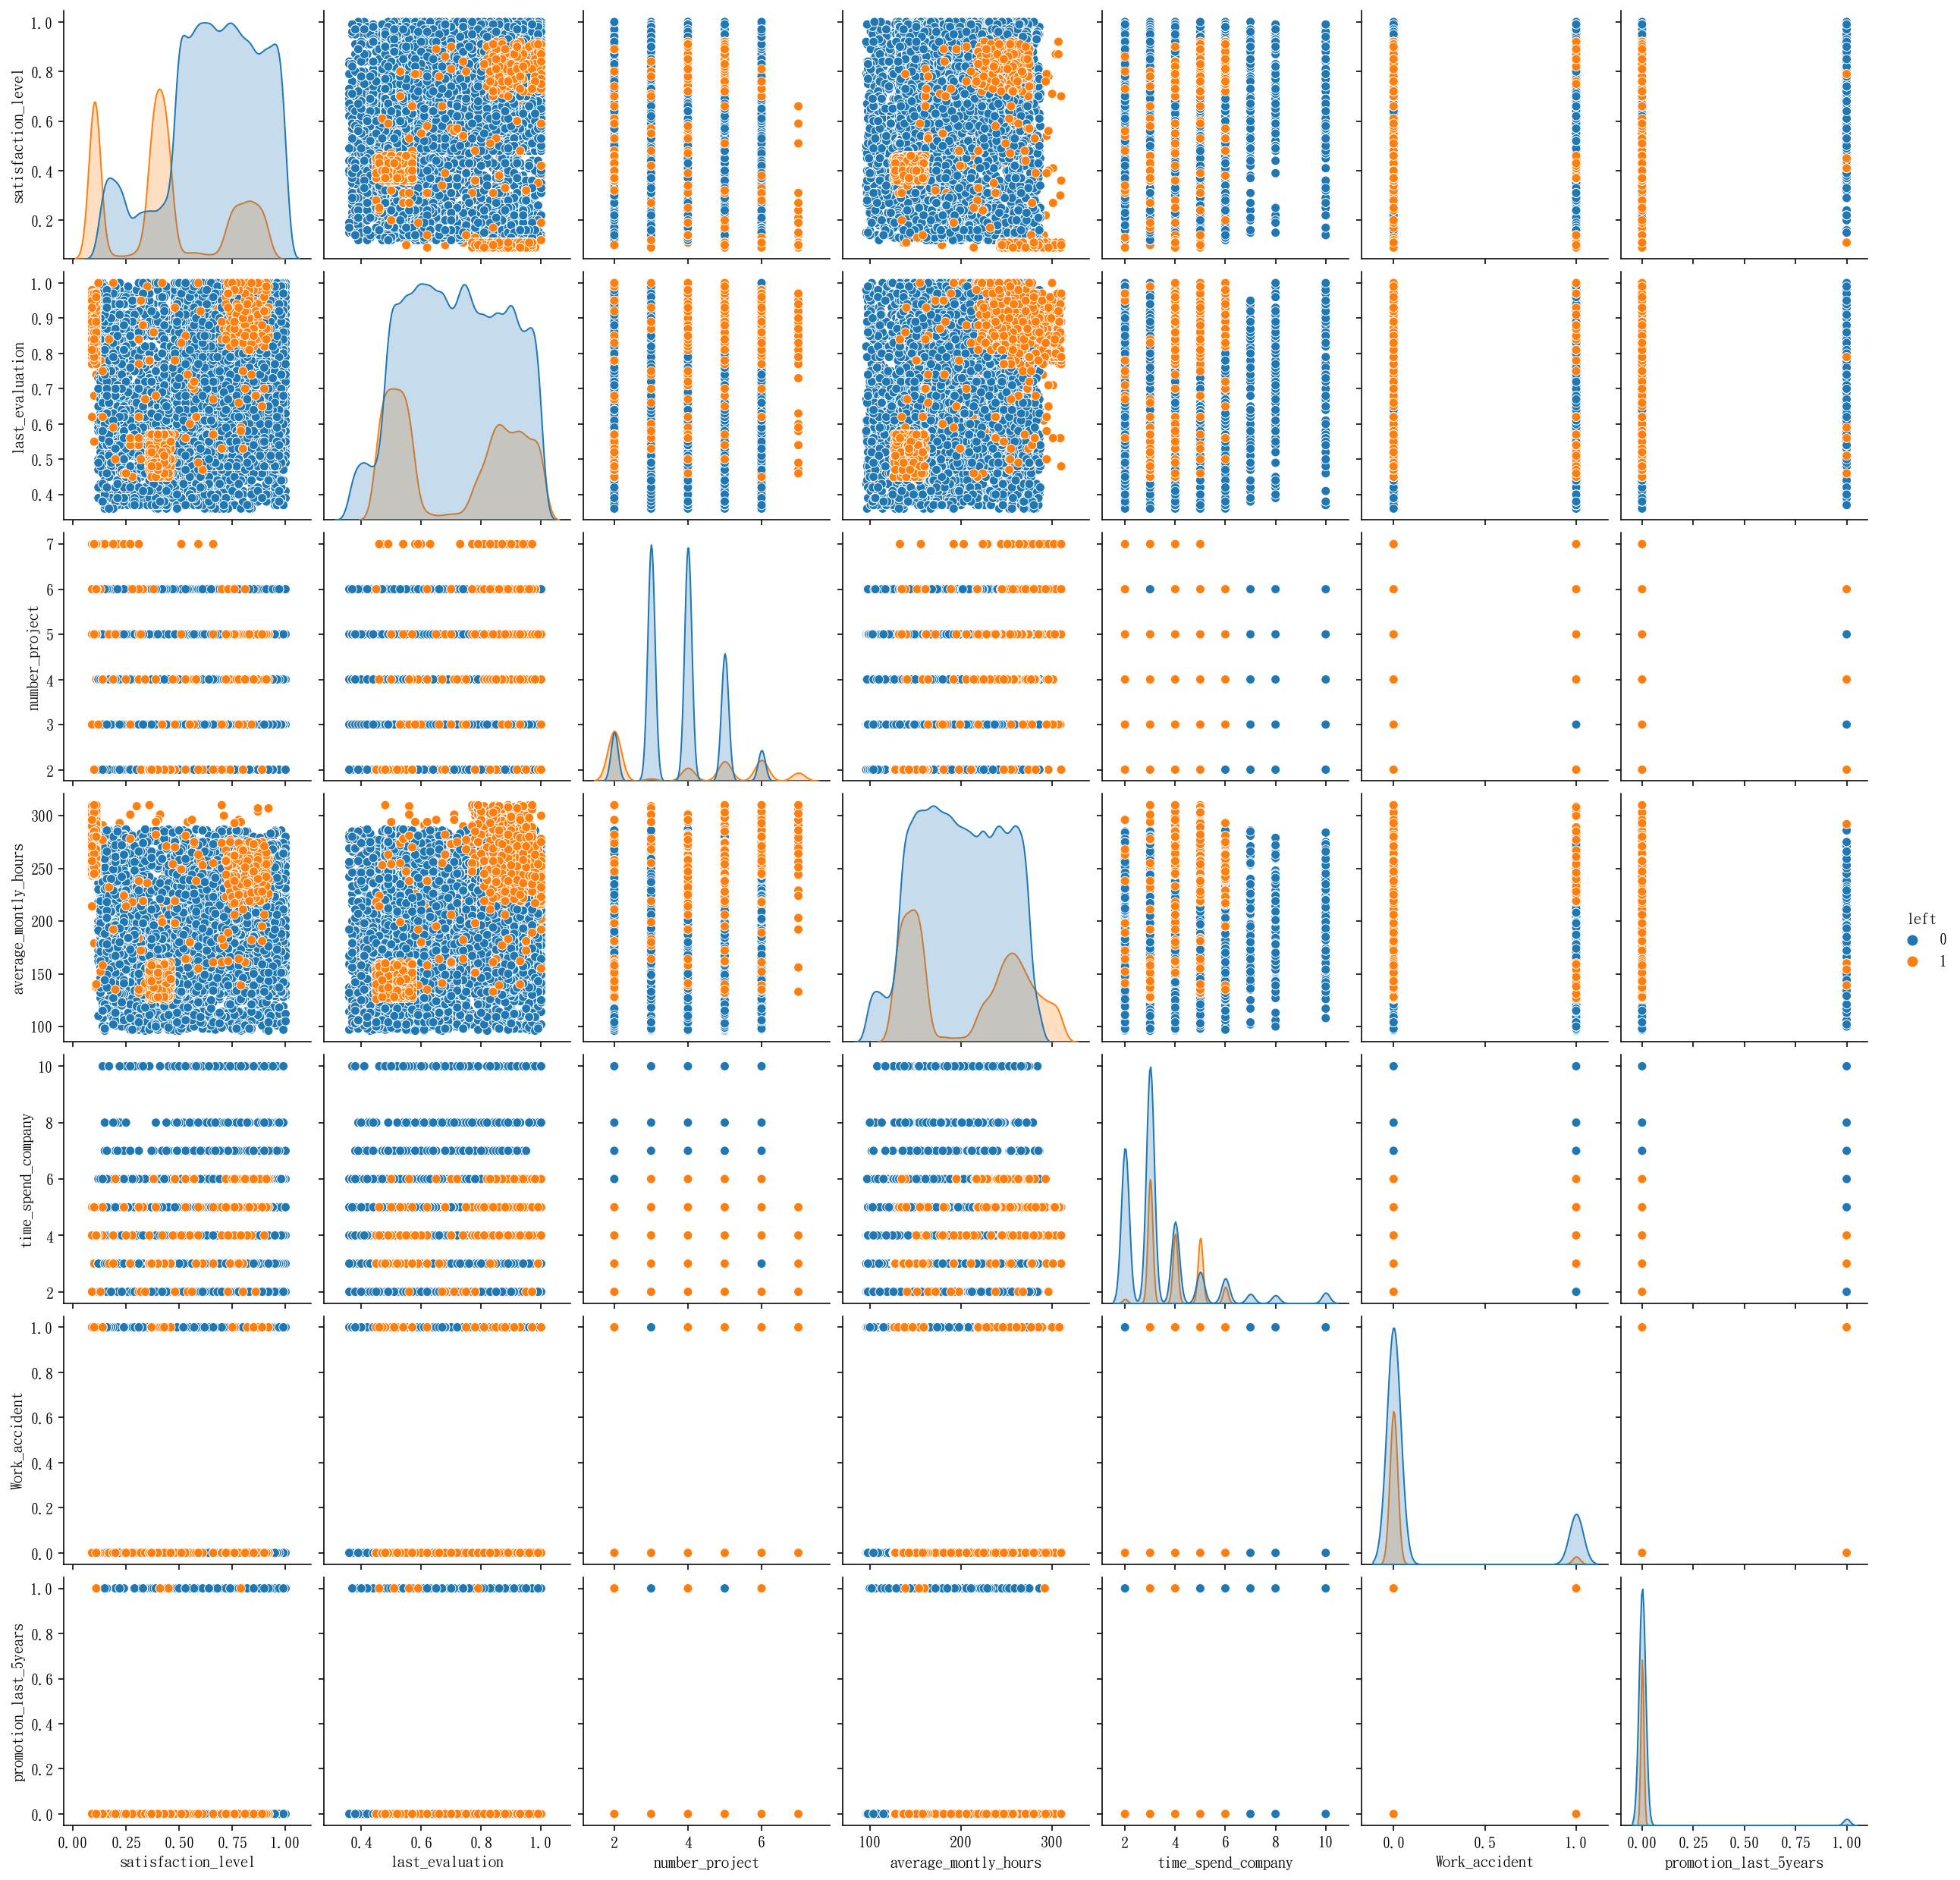

In [8]:
#檢視變數之間的關係
sns.pairplot(df,hue='left',diag_kws={'bw':0.1})

藍色代表留下來，橘色代表離開。可以發現:1.由satisfaction_level可知滿意度高的會留下
2.在last_evaluation中，表現特好或特差的容易離開
3.而number_project則顯示專案特多或特少都容易離開
4.最後在average_montly_hours發現每月工時過高或過低想離開
5.其他沒發現明顯關係

<AxesSubplot:>

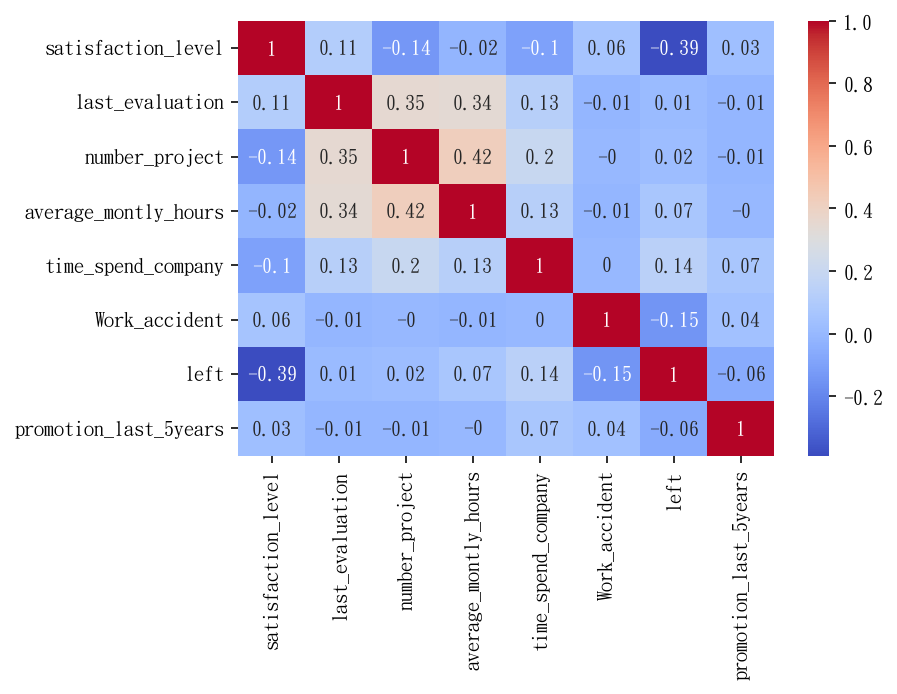

In [9]:
#使用相關係數
sns.heatmap(df.corr().round(2),annot=True,cmap='coolwarm')

變數中最相關的是每月工作時數和專案數(0.42)，離職和對公司滿意度(-0.39)，工作時數和最近一次評估(0.35)

In [10]:
#檢視所有連續變數和目標值的關係
df.drop('left',axis=1).corrwith(df['left']).round(2)

satisfaction_level      -0.39
last_evaluation          0.01
number_project           0.02
average_montly_hours     0.07
time_spend_company       0.14
Work_accident           -0.15
promotion_last_5years   -0.06
dtype: float64

可以看出:
1.滿意度越高越不容易離開
2.月工作時間越長，離職率越高
3.在公司待的年數越長，離職率越高
4.經過事故的員工離職率較低

In [11]:
#檢視薪水高低和離職關係
df_left_salary = df.groupby(['left','salary']).size().unstack(1)
df_left_salary = df_left_salary[['low','medium','high']]
print(df_left_salary)
print(df_left_salary/df_left_salary.sum())

salary   low  medium  high
left                      
0       5144    5129  1155
1       2172    1317    82
salary       low    medium      high
left                                
0       0.703116  0.795687  0.933711
1       0.296884  0.204313  0.066289


薪資越高，留下來的機率越高

<AxesSubplot:>

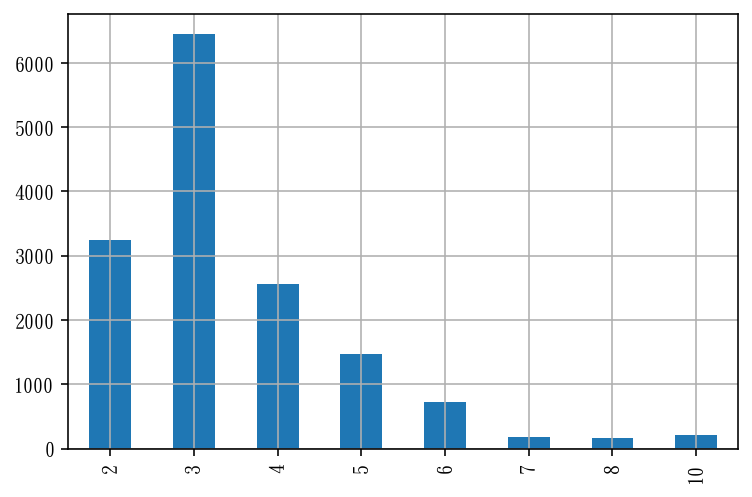

In [12]:
#探討員工在公司待了幾年
df['time_spend_company'].value_counts().sort_index().\
plot(kind='bar',grid=True)

大部分人待2到4年，該資料年資範圍2-10年

<AxesSubplot:xlabel='time_spend_company'>

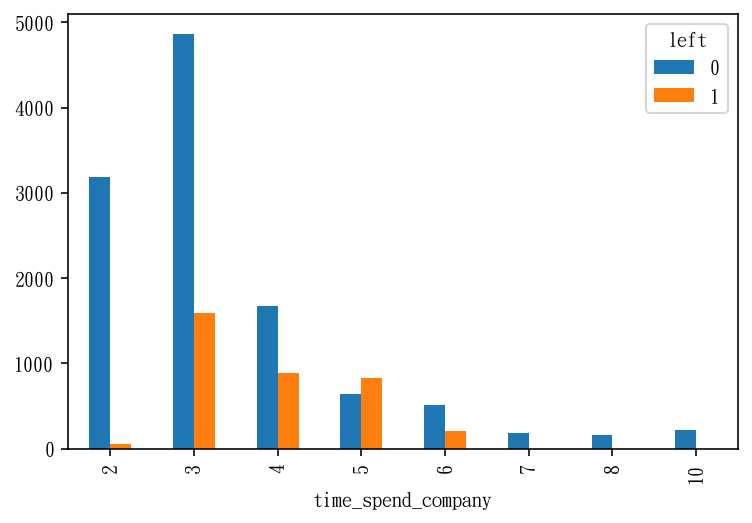

In [13]:
#離職與工作年資的關係
df_left_time = df.groupby(['left','time_spend_company']).size().unstack(0)
df_left_time.plot(kind='bar')

3到5年離職人數是最多的，在第5年離職人數多於留下的人數，而到第7年後就沒人離職了

<AxesSubplot:xlabel='sales'>

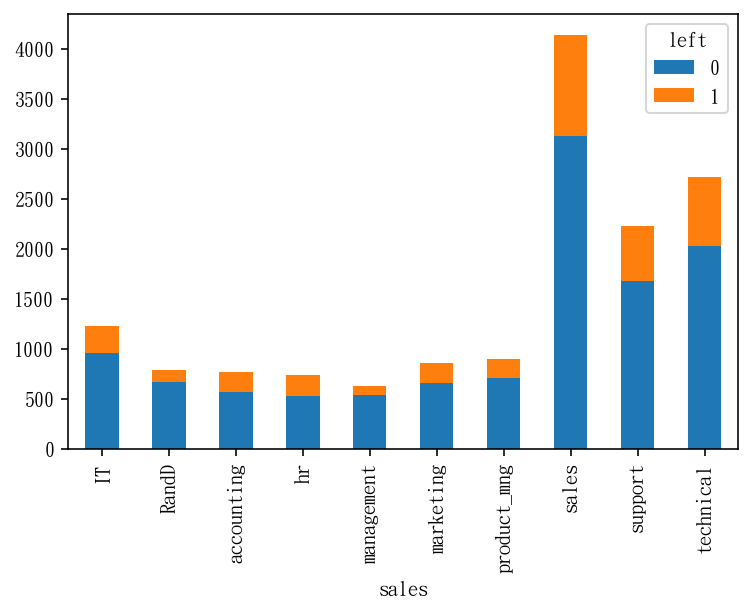

In [14]:
#離職與部門的關係
df.groupby(['left','sales']).size().unstack(0).plot(kind='bar',stacked=True)

銷售部門累積人數最多，離職的人數也最多

In [4]:
#定義與切割
x = df.drop('left',axis=1)
y = df['left']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33)

In [5]:
#整理資料
x_col_num = x.select_dtypes(exclude = 'object').columns
x_col_cat = x.select_dtypes(include = 'object').columns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
data_pl = ColumnTransformer([('num',StandardScaler(),x_col_num),('cat',OneHotEncoder(),x_col_cat)])

In [7]:
#檢視基礎預測結果
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report#正確率、混亂矩陣、綜合報告
dmy = DummyClassifier(strategy='most_frequent')
dmy.fit(x_train,y_train)
dmy.score(x_train,y_train)
y_pred = dmy.predict(x_test)
print('整體正確率:',accuracy_score(y_test,y_pred).round(2))
print('混亂矩陣')
print(pd.DataFrame(confusion_matrix(y_test,y_pred),index=['實際1','實際2'],columns=['預測1','預測2']))
print('綜合報告')
print(classification_report(y_test,y_pred))

整體正確率: 0.76
混亂矩陣
      預測1  預測2
實際1  3752    0
實際2  1198    0
綜合報告
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3752
           1       0.00      0.00      0.00      1198

    accuracy                           0.76      4950
   macro avg       0.38      0.50      0.43      4950
weighted avg       0.57      0.76      0.65      4950



In [8]:
#先使用四個預測模型來比較出最佳模型來預測
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
model_pl=Pipeline([('preprocess',data_pl),('model',LogisticRegression())])
param_grid = {'model':[LogisticRegression(),SVC(),KNeighborsClassifier(),DecisionTreeClassifier(max_depth=10)]}
gs=GridSearchCV(model_pl,param_grid=param_grid,cv=5,return_train_score=True)
gs.fit(x_train,y_train)
score=gs.best_estimator_.score(x_test,y_test)
print('最佳預測模型和參數',gs.best_params_['model'])
print('訓練集的最佳結果',gs.best_score_.round(3))
print('測試集訓練結果',score.round(3))
y_pred = gs.best_estimator_.predict(x_test)
print('混亂矩陣')
print(pd.DataFrame(confusion_matrix(y_test,y_pred),index=['實際1','實際2'],columns=['預測1','預測2']))
print('綜合報告')
print(classification_report(y_test,y_pred))

最佳預測模型和參數 DecisionTreeClassifier(max_depth=10)
訓練集的最佳結果 0.977
測試集訓練結果 0.981
混亂矩陣
      預測1   預測2
實際1  3725    27
實際2    67  1131
綜合報告
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3752
           1       0.98      0.94      0.96      1198

    accuracy                           0.98      4950
   macro avg       0.98      0.97      0.97      4950
weighted avg       0.98      0.98      0.98      4950



決策樹為最佳選擇，測試集結果為0.979

In [19]:
#使用硬、軟投票器確定正確率是否有上升
from sklearn.ensemble import VotingClassifier
model_pl_lr = make_pipeline(data_pl,LogisticRegression())
model_pl_svc = make_pipeline(data_pl,SVC())
model_pl_knn = make_pipeline(data_pl,KNeighborsClassifier())
model_pl_tree = make_pipeline(data_pl,DecisionTreeClassifier(max_depth=10))
vc=VotingClassifier([('lr',model_pl_lr),('svc',model_pl_svc),('knn',model_pl_knn),('tree',model_pl_tree)],voting='hard')
vc.fit(x_train,y_train)
train_score=vc.score(x_train,y_train)
test_score=vc.score(x_test,y_test)
print("訓練集預測結果",train_score)
print("測試集預測結果",test_score)

訓練集預測結果 0.9760175141805155
測試集預測結果 0.9682828282828283


In [20]:
model_pl_svc = make_pipeline(data_pl,SVC(probability=True))
vc=VotingClassifier([('lr',model_pl_lr),('svc',model_pl_svc),('knn',model_pl_knn),('tree',model_pl_tree)],voting='soft')
vc.fit(x_train,y_train)
train_score=vc.score(x_train,y_train)
test_score=vc.score(x_test,y_test)
print("訓練集預測結果",train_score)
print("測試集預測結果",test_score)

訓練集預測結果 0.9806945964772614
測試集預測結果 0.9705050505050505


使用硬、軟投票器其正確率並沒有好於決策樹的結果

In [21]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [27]:
#再使用各式組合預測器來比較其正確率是否有上升
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
model_pl=Pipeline([('preprocess',data_pl),('model',LogisticRegression())])
param_grid = {'model':[RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),XGBClassifier(),BaggingClassifier()]}
gs=GridSearchCV(model_pl,param_grid=param_grid,cv=5,return_train_score=True)
gs.fit(x_train,y_train)
score=gs.best_estimator_.score(x_test,y_test)
print('最佳預測模型和參數',gs.best_params_['model'])
print('訓練集的最佳結果',gs.best_score_.round(3))
print('測試集訓練結果',score.round(3))
y_pred = gs.best_estimator_.predict(x_test)
print('混亂矩陣')
print(pd.DataFrame(confusion_matrix(y_test,y_pred),index=['實際1','實際2'],columns=['預測1','預測2']))

最佳預測模型和參數 RandomForestClassifier()
訓練集的最佳結果 0.985
測試集訓練結果 0.988
混亂矩陣
      預測1   預測2
實際1  3774    13
實際2    48  1115


隨機森林演算法為最佳選擇，測試集結果為0.987，比決策樹模型要佳，故可以採用此方法預測員工離職機率

In [33]:
#用隨機森林法變數的重要性
model_pl_rf=Pipeline([('preprocess',data_pl),('model',RandomForestClassifier())])
model_pl_rf.fit(x_train,y_train)
imp = model_pl_rf.named_steps['model'].feature_importances_
feature_names = model_pl_rf.named_steps['preprocess'].\
named_transformers_['cat'].get_feature_names_out(['sales','salary'])
cols = x_col_num.tolist()+feature_names.tolist()
pd.DataFrame(zip(cols,imp),columns=['欄位','係數']).\
sort_values(by='係數',ascending=False)

,欄位,係數
0,satisfaction_level,0.311414
4,time_spend_company,0.184429
2,number_project,0.181060
3,average_montly_hours,0.150449
1,last_evaluation,0.121452
5,Work_accident,0.011097
18,salary_low,0.008577
17,salary_high,0.005062
19,salary_medium,0.003489
16,sales_technical,0.003427


滿意度、在公司幾年、平均每月工時、專案個數和最後一次評等是前五重要的變數

In [34]:
#尋找隨機兂林最佳參數
model_pl=Pipeline([('preprocess',data_pl),('model',LogisticRegression())])
param_grid = [
    {'model':[RandomForestClassifier()],'model__n_estimators':[50,100,150,200,300,400,500]}
   ]
gs=GridSearchCV(model_pl,param_grid=param_grid,cv=5,return_train_score=True)
gs.fit(x_train,y_train)
score=gs.best_estimator_.score(x_test,y_test)
print('最佳預測模型和參數',gs.best_params_['model'])
print('訓練集的最佳結果',gs.best_score_.round(3))
print('測試集訓練結果',score.round(3))
y_pred = gs.best_estimator_.predict(x_test)
print('混亂矩陣')
print(pd.DataFrame(confusion_matrix(y_test,y_pred),index=['實際1','實際2'],columns=['預測1','預測2']))

最佳預測模型和參數 RandomForestClassifier(n_estimators=150)
訓練集的最佳結果 0.986
測試集訓練結果 0.988
混亂矩陣
      預測1   預測2
實際1  3776    11
實際2    47  1116


可以採用n_estimators=150做為隨機森林法設定的最佳參數

AUC分數:0.9869773295573103


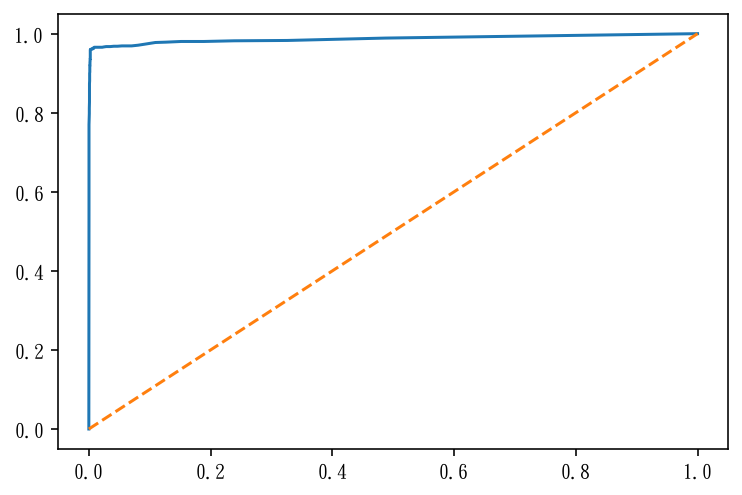

In [29]:
#繪製ROC圖
from sklearn.metrics import roc_curve,roc_auc_score
y_pred_porba = model_pl_rf.predict_proba(x_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,y_pred_porba)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],ls='--')
print(f'AUC分數:{roc_auc_score(y_test,y_pred_porba)}')

AUC分數:0.988代表分類表現相當傑出，可從此圖判斷可能要留下的員工。

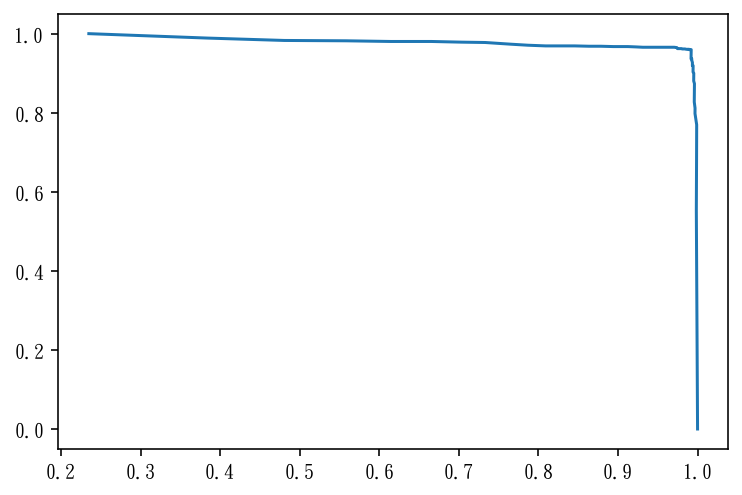

In [30]:
#繪製PRC圖
from sklearn.metrics import precision_recall_curve
fpr,tpr,thresholds = precision_recall_curve(y_test,y_pred_porba)
plt.plot(fpr,tpr)

可從此圖準確判斷要離開的員工

結論:預測員工離職最佳模型為隨機森林演算法，其測試集結果為0.987，故可以採用此方法預測員工離職機率，並在判斷時著重參考滿意度、在公司幾年、平均每月工時、專案個數和最後一次評等的五大指標，可利用ROC或PRC圖(提高門檻)的方式來進行更好的員工去留應對。